In [2]:
!pip install -r project/requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import string
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import openpyxl
import statistics
from fuzzywuzzy import fuzz
from nltk.translate.bleu_score import sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


cuda


In [160]:
data_path = '/home/ec2-user/SageMaker/project/data/grouped_data/system/'

files = ['SAP.csv', 'Oracle.csv', 'MSDynamics.csv']
df = pd.DataFrame()

for file in files:
    df_system = pd.read_csv(data_path+file, dtype=str,header=0)
    df = pd.concat([df, df_system], sort=False)

df.head(3)

,System,Division,Industry,Source Account #,Source Account Description,Target Account #,Target Account Description,Source Level 1,Source Level 2,Source Level 3,...,Source Level 5,Source Level 6,Source Level 7,Source Level 8,Source Level 9,Source Level 10,Target Level 1,Target Level 2,Target Level 3,Target Level 4
0,SAP,Manufacturing,Drugs,101397,INV REVAL - GROSS SC,12250000,Inventory Reval. - gross - Std. costs,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAP,Manufacturing,Drugs,100447,BAR07-SCOTIA-BDS,10000000,Cash,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SAP,Manufacturing,Drugs,101000,kookmin Bank(SeoCho),10000000,Cash,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
len(df)

22527

In [31]:
# def preprocess_text(text):

#     text = str(text)
#     text = text.lower().strip()
#     text = "".join([char for char in text if char not in string.punctuation+string.digits])
#     text = re.sub('\\s+', ' ', text)

#     return text

def preprocess_text(text):
    '''
    Text preprocessing function for account names. 
    '''
    text = str(text)
    chars = [char for char in text]
    chars.append(' ')

    idx_slices = [0]
    for i in range(len(chars)):
        if i == 0: continue
        #want to keep letters connected with & together; cast to lower to avoid slice
        if chars[i] == '&': chars[i+1] = chars[i+1].lower() 
        #want to keep consecutive letters together
        if chars[i-1] in string.ascii_uppercase: continue

        if chars[i] in string.ascii_uppercase: idx_slices.append(i)

    #slice text at uppercases
    text = " ".join([text[i:j] for i,j in zip(idx_slices, idx_slices[1:]+[None])])
    text = text.lower().strip()
    text = re.sub('-', ' ', text)
    text = "".join([char for char in text if char not in string.punctuation+string.digits])
    text = re.sub('\\s+', ' ', text).strip()

    return text


def plot_loss(model_name, losses, n_iters, benchmark_every, learning_rate):
    x = np.arange(0, n_iters, benchmark_every)
    y = losses
    plt.figure()
    plt.plot(x, y)
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    #current_dir = os.getcwd()
    # save_to = os.path.join(current_dir, r'loss_plots')
    # if not os.path.exists(save_to): os.makedirs(save_to)
    # plt.savefig(os.path.join(save_to, f'loss_{model_name}_{learning_rate}.jpg'))
    plt.show()


In [56]:
def format_df(df, model_type='short'):

    if model_type == 'long':
        source_data = pd.DataFrame({'Source Level 1': df['Source Level 1'].copy(), 'Source Level 2': df['Source Level 2'].copy(), 
                                    'Source Level 3': df['Source Level 3'].copy(), 'Source Account Description': df['Source Account Description'].copy()})  
        
        target_data = pd.DataFrame({'Target Level 1': df['Target Level 1'].copy(), 'Target Level 2': df['Target Level 2'].copy(), 
                                    'Target Level 3': df['Target Level 3'].copy(), 'Target Account Description': df['Target Account Description'].copy()})
        
    elif model_type == 'short':
        source_data = pd.DataFrame({'Source Account Description': df['Source Account Description'].copy()})
        
        target_data = pd.DataFrame({'Target Account Description': df['Target Account Description'].copy()})
        
    else: raise ValueError("Invalid input for model type: acceptable arguments include ['short', 'long']")
        
    return source_data, target_data
        
        
def preprocess_data_for_model(source_data, target_data, split_data=True, shuffle=True, test_size=0.2, verbose=True):

    for col in source_data.columns:
        source_data[col] = source_data[col].apply(preprocess_text)
    for col in target_data.columns:
        target_data[col] = target_data[col].apply(preprocess_text)

    if(split_data):
        src_train, src_test, tar_train, tar_test = train_test_split(source_data, target_data, test_size=test_size, shuffle=shuffle) #, random_state=5)
        if(verbose): print(f'Training size: {len(src_train)}  \nTesting size: {len(src_test)}')
        return src_train, src_test, tar_train, tar_test
    else:
        return source_data, target_data
    
source_data, target_data = format_df(df, model_type='long')
x_train, x_test, y_train, y_test = preprocess_data_for_model(source_data, target_data, test_size=0.15)
x_train.head(3)

Training size: 19147  
Testing size: 3380


,Source Level 1,Source Level 2,Source Level 3,Source Account Description
7861,nan,nan,nan,cred fixed assets art income law
14053,m mars financial statement v full trial balan,net financing,total treasury assets,deferred financing fees
782,assets,current assets,inventory,balance sheet direct despatch control account


In [57]:
y_train.head(3)

,Target Level 1,Target Level 2,Target Level 3,Target Account Description
7861,nan,nan,nan,sciencetech tax pay
14053,assets,other assets non current,other assets non current,deferred financing fees asset
782,assets,current assets,inventory,inventory direct dispatch control account


## Word Encoding

In [58]:
SOS_token = 0
EOS_token = 1

class Vocabulary:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNKNOWN"}
        self.n_words = 3  # Count SOS, EOS, UNKNOWN

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [59]:
def create_pairs(x_data, y_data):

    x_data = x_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    sources, targets = [], []
    
    for i in range(len(x_data)):
        source_level_text, target_level_text = [], []

        for col in x_data:
            s_text = x_data.loc[i, col]
            source_level_text.append(s_text)
        for col in y_data:
            t_text = y_data.loc[i, col]
            target_level_text.append(t_text)

        sources.append(source_level_text)
        targets.append(target_level_text)

    pairs = list((zip(sources, targets)))
    
    return pairs

def create_vocabulary(set1, set2, x_data, y_data):
    
    input_set = Vocabulary(set1)
    output_set = Vocabulary(set2)
    pairs = create_pairs(x_data, y_data)

    for pair in pairs:
        full_source_string = " ".join(pair[0])
        full_target_string = " ".join(pair[1])
        input_set.add_sentence(full_source_string)
        output_set.add_sentence(full_target_string)

    return input_set, output_set, pairs


In [60]:
input_set, output_set, pairs = create_vocabulary('legacy', 'new', x_train, y_train)
pairs[0]

(['nan', 'nan', 'nan', 'cred fixed assets art income law'],
 ['nan', 'nan', 'nan', 'sciencetech tax pay'])

In [61]:
def indexes_from_sentence(set, sentence):
    sentence_indexes = []
    for word in sentence.split(' '):
        if word not in set.word2index:
            sentence_indexes.append(2)
        else:
            sentence_indexes.append(set.word2index[word])
            
    return sentence_indexes

def tensor_from_sentence(set, sentence):
    indexes = indexes_from_sentence(set, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_text_list(text_list, input_set, output_set):
    tensors = []
    for level in text_list:
        print(level)
        tensor = tensor_from_sentence(input_set, level)
        tensors.append(tensor)
        
    return tensors

def tensors_from_pair(pair, input_set, output_set):
    source = pair[0]
    target = pair[1]
    source_target_pairwise_tensors = []

    for i in range(len(target)):
        source_level = source[i]
        target_level = target[i]
        source_level_tensor = tensor_from_sentence(input_set, source_level)
        target_level_tensor = tensor_from_sentence(output_set, target_level)
        source_target_pairwise_tensors.append((source_level_tensor, target_level_tensor))

    return source_target_pairwise_tensors

tensors_from_pair(pairs[0], input_set, output_set)[3]

(tensor([[4],
         [5],
         [6],
         [7],
         [8],
         [9],
         [1]], device='cuda:0'),
 tensor([[4],
         [5],
         [6],
         [1]], device='cuda:0'))

## Model

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.name = 'Decoder'
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=100):
        super(AttnDecoder, self).__init__()
        self.name = 'AttnDecoder'
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

In [64]:
def run_iter(tensors_pair, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, model_type, max_length=100, teacher_forcing_ratio=0.0):

    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    if(model_type == 'long'):
        L1_loss, L2_loss, L3_loss, L4_loss, report_loss = 0, 0, 0, 0, 0
        level_losses = [L1_loss, L2_loss, L3_loss, L4_loss]
        
    elif(model_type=='short'):
        description_loss, report_loss = 0, 0
        level_losses = [description_loss]
        
    else: raise ValueError("Invalid input for model type: acceptable arguments include ['short', 'long']")
          
    target_lengths = []

    for i in range(len(tensors_pair)):
        source_level_tensor = tensors_pair[i][0]
        target_level_tensor = tensors_pair[i][1]
        source_level_length = source_level_tensor.size(0)
        target_level_length = target_level_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        #loop through each word of the source level
        for en in range(source_level_length):
            encoder_output, encoder_hidden = encoder(source_level_tensor[en], encoder_hidden)
            encoder_outputs[en] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for de in range(target_level_length):
                if(decoder.name == 'AttnDecoder'):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                level_losses[i] += criterion(decoder_output, target_level_tensor[de])
                decoder_input = target_level_tensor[de]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for de in range(target_level_length):
                if(decoder.name == 'AttnDecoder'):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                level_losses[i] += criterion(decoder_output, target_level_tensor[de])
                if decoder_input.item() == EOS_token:
                    break
            
        level_losses[i].backward(retain_graph=True)
        target_lengths.append(target_level_length)

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_target_length = np.sum(target_lengths)
    report_loss = level_losses[-1].item()
    #for level_loss in level_losses:
    #    loss += level_loss.item()

    return report_loss / target_lengths[-1]


def train_model(input_set, output_set, encoder, decoder, pairs, n_iters, save_path, model_name, model_type, hidden_size, dropout=None, attention=False, benchmark_every=100, 
                save_every=100, learning_rate=0.01, tf_ratio=0.0, max_length=100, verbose=False):
    
    if (save_every > n_iters) or (benchmark_every > n_iters):
        raise ValueError('Parameter num_iters must be larger than paramters save_every and benchmark_loss_every')
    if n_iters % benchmark_every != 0:
        raise ValueError('Parameter num_iters must be evenly divisible by parameter benchmark_loss_every')

    if(verbose): print('\ntraining model...')
    loss_total = 0  # Reset every benchmark_every
    losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    
    #create training pairs randomly from given list of pairs
    training_pairs = [tensors_from_pair(random.choice(pairs), input_set, output_set) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    #run iteration for each training pair
    for i in tqdm(range(1, n_iters + 1)):
        tensors_pair = training_pairs[i - 1]

        loss = run_iter(tensors_pair, encoder, decoder, encoder_optimizer, decoder_optimizer, 
                        criterion, model_type, max_length=max_length, teacher_forcing_ratio=tf_ratio)
        
        loss_total += loss
        #record loss
        if i % benchmark_every == 0:
            loss_avg = loss_total / benchmark_every
            losses.append(loss_avg)
            loss_total = 0
        #save model parameters
        if i % save_every == 0:
            torch.save({'en_sd': encoder.state_dict(),
                        'de_sd': decoder.state_dict(),
                        'en_opt': encoder_optimizer,
                        'de_opt': decoder_optimizer,
                        'en_opt_sd': encoder_optimizer.state_dict(),
                        'de_opt_sd': decoder_optimizer.state_dict(),
                        'loss': losses[-1],
                        'input_dict': input_set.__dict__,
                        'output_dict': output_set.__dict__,
                        'hidden_size': hidden_size,
                        'dropout': dropout, 
                        'max_length': max_length,
                        'attention': attention,
                        'model_type': model_type,
                        }, os.path.join(save_path, '{}_{}_{:.3f}.hdf5'.format(model_name, i, losses[-1])))

    plot_loss(model_name, losses, n_iters, benchmark_every, learning_rate)


training model...


100%|██████████| 100000/100000 [1:31:59<00:00, 18.12it/s] 


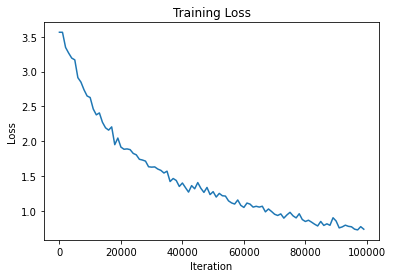

In [65]:
encoder = Encoder(input_set.n_words, 256).to(device)
decoder = AttnDecoder(256, output_set.n_words).to(device)

save_path = os.getcwd()

train_model(input_set, output_set, encoder, decoder, pairs, n_iters=100000, save_path=save_path, model_name='long_model',
            model_type='long', hidden_size=256, dropout=0.1, attention=True, save_every=2000, learning_rate=0.01, benchmark_every=1000, verbose=True)

## Inference

In [68]:
def calc_bleu_score(reference, hypothesis):
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    return round(sentence_bleu(reference, hypothesis, weights=(1,)), 3)
    
    
def calc_scores(predictions, targets, model_type):

    l1_scores, l2_scores, l3_scores, l4_scores = [],[],[],[]
    description_similarities = []
    
    for i in range(len(predictions)):
        pred = predictions[i]
        tar = targets[i]
        
        if(model_type == 'short'):
            bleu_score = calc_bleu_score(tar[0], pred)
            description_similarity = fuzz.token_sort_ratio(tar, pred)/100
            description_similarities.append(description_similarity)
            l4_scores.append(bleu_score)
            
        elif(model_type == 'long'):        
            for j in range(len(pred)):
                bleu_score = calc_bleu_score(tar[j], pred[j])
                if j == 0: l1_scores.append(bleu_score)
                elif j == 1: l2_scores.append(bleu_score)
                elif j == 2: l3_scores.append(bleu_score)
                else: 
                    l4_scores.append(bleu_score)
                    description_similarity = fuzz.token_sort_ratio(tar[j], pred[j])/100
                    description_similarities.append(description_similarity)
                    break
                    
        else: raise ValueError("Invalid input for model type: acceptable arguments include ['short', 'long']")
            

    return l1_scores, l2_scores, l3_scores, l4_scores, description_similarities

def load_model(model_path, model_name, device, attention=False):

    model = torch.load(model_path+model_name, map_location=device)
    model_type = model['model_type']

    max_length = model['max_length']
    input_set = Vocabulary('legacy')
    input_set.__dict__ = model['input_dict']
    output_set = Vocabulary('new')
    output_set.__dict__ = model['output_dict']

    encoder = Encoder(input_set.n_words, model['hidden_size']).to(device)

    attention = model['attention']
    if attention == True: 
        decoder = AttnDecoder(model['hidden_size'], output_set.n_words, dropout_p=0.1, max_length=max_length).to(device)
    else:
        decoder = Decoder(model['hidden_size'], output_set.n_words).to(device)

    encoder.load_state_dict(model['en_sd'])
    decoder.load_state_dict(model['de_sd'])

    encoder_optimizer = model['en_opt']
    decoder_optimizer = model['de_opt']
    encoder_optimizer.load_state_dict(model['en_opt_sd'])
    decoder_optimizer.load_state_dict(model['de_opt_sd'])

    return input_set, output_set, encoder, decoder, max_length, model_type

In [76]:
def predict(input_set, output_set, encoder, decoder, account, model_type, max_length=100):

    level_confidence_scores = []
    decoded_output = []
    
    with torch.no_grad():
        
        for i in range(len(account)):
            input_level = account[i]
            input_level_tensor = tensor_from_sentence(input_set, input_level)
            input_level_length = input_level_tensor.size()[0]
            
            encoder_hidden = encoder.initHidden()
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

            for en in range(input_level_length):
                encoder_output, encoder_hidden = encoder(input_level_tensor[en], encoder_hidden)
                encoder_outputs[en] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_hidden = encoder_hidden

            decoded_level_words = []
            decoder_attentions = torch.zeros(max_length, max_length)
            #record values for each decoded word
            top_values = []

            for de in range(max_length):
                if(decoder.name == 'AttnDecoder'):
                    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                    decoder_attentions[de] = decoder_attention.data
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
                topv, topi = decoder_output.data.topk(1)
                top_values.append(np.exp(topv.item())*100)

                if topi.item() == EOS_token:
                    decoded_level_words.append('<EOS>')
                    break
                else:
                    #translate decoder output into word and append
                    decoded_level_words.append(output_set.index2word[topi.item()])

                decoder_input = topi.squeeze().detach()

            decoded_output.append(decoded_level_words)
            level_confidence = statistics.mean(top_values)
            level_confidence_scores.append(level_confidence)
            
        #take average of decoded word values as confidence score
        confidence_score = statistics.mean(level_confidence_scores)

        return decoded_output, decoder_attentions[:de + 1], confidence_score
    
            
def predict_on_unknown(input_set, output_set, encoder, decoder, model_type, df, max_length=100, verbose=False):
    '''
    For a list of legacy accounts, predict a target for each account. Returns a dataframe with the legacy accounts, predicted target accounts, and respective confidence scores.
    '''
    
    if(model_type == 'short'):
        source_data = {'Source Account Description': df['Source Account Description'].copy()}
        
    elif(model_type == 'long'):     
        source_data = {'Source Level 1': df['Source Level 1'].copy(),
                       'Source Level 2': df['Source Level 2'].copy(),
                       'Source Level 3': df['Source Level 3'].copy(),
                       'Source Account Description': df['Source Account Description'].copy()}
        
    else: raise ValueError("Invalid input for model type: acceptable arguments include ['short', 'long']")

    sources = pd.DataFrame(source_data)
    
    if(verbose): print('Generating predictions...')
    predictions, confidence_scores = [], []
    for a in tqdm(range(len(sources))):
        account = sources.iloc[a, :].tolist()
        #predict on input account
        output, _, confidence_score = predict(input_set, output_set, encoder, decoder, account, model_type=model_type, max_length=max_length)
        prediction = []
        for pred_level in output:
            pred_level = " ".join(pred_level[:-1]) #drop EOS token
            prediction.append(pred_level)
            
        predictions.append(prediction)
        confidence_scores.append(confidence_score)

    df_out = sources.copy()
    
    if(model_type == 'short'):
            df_out['Prediction Account Description'] = [p[0] for p in predictions] #remove list brackets from each acct
            df_out['Confidence Score'] = confidence_scores
    else:     
        df_out['Prediction Level 1'] = list(list(zip(*predictions))[0])
        df_out['Prediction Level 2'] = list(list(zip(*predictions))[1])
        df_out['Prediction Level 3'] = list(list(zip(*predictions))[2])
        df_out['Prediction Account Description'] = list(list(zip(*predictions))[3])
        df_out['Confidence Score'] = confidence_scores

    return df_out

def evaluate_output(df_predictions, df_with_targets, model_type, verbose=True):
    
    #df_with_targets = df_with_targets.reset_index(drop=True)
    if(model_type == 'short'):
        target_data = {'Target Account Description': df_with_targets['Target Account Description']}
        
    elif(model_type == 'long'):
        target_data = {'Target Level 1': df_with_targets['Target Level 1'],
                       'Target Level 2': df_with_targets['Target Level 2'],
                       'Target Level 3': df_with_targets['Target Level 3'],
                       'Target Account Description': df_with_targets['Target Account Description']}
    
    else: raise ValueError("Invalid input for model type: acceptable arguments include ['short', 'long']")
    
    df_targets = pd.DataFrame(target_data)
    
    predictions, targets = [], []
    for i in range(len(df_predictions)):
        if(model_type == 'short'):
            predictions.append(df_predictions.loc[i, 'Prediction Account Description'])
        else:
            predictions.append(df_predictions.loc[i, 'Prediction Level 1':'Prediction Account Description'].tolist())
        targets.append(df_targets.iloc[i, :].tolist())
    
    l1_scores, l2_scores, l3_scores, l4_scores, description_similarities = calc_scores(predictions, targets, model_type)
    
    if(model_type == 'short'):
        score_data = {'Predicted Description Bleu Score': l4_scores,
                      'Predicted Description Similarity':description_similarities}
        if(verbose):
             print(f'\nDescription Bleu score average: {np.mean(l4_scores):.2f} \
                     \nAverage predicted description (L4) similarity to target: {np.mean(description_similarities)*100:.2f}%')
    else:
        score_data = {'Predicted Level 1 Bleu Score': l1_scores, 
                      'Predicted Level 2 Bleu Score': l2_scores,
                      'Predicted Level 3 Bleu Score': l3_scores,
                      'Predicted Description Bleu Score': l4_scores,
                      'Predicted Description Similarity':description_similarities}
        if(verbose):
             print(f'\nL1 Bleu score average: {np.mean(l1_scores):.2f} \
                     \nL2 Bleu score average: {np.mean(l2_scores):.2f} \
                     \nL3 Bleu score average: {np.mean(l3_scores):.2f} \
                     \nL4 Bleu score average: {np.mean(l4_scores):.2f} \
                     \nAverage predicted description (L4) similarity to target: {np.mean(description_similarities)*100:.2f}%')
    
    df_scores = pd.DataFrame(score_data)
    
    df_out = pd.concat([df_predictions, df_targets, df_scores], axis=1)
    
    return df_out


#### Long Model

In [77]:
import os
cwd = os.path.abspath(os.getcwd())
model_path = cwd + '/'

model_name = 'long_model_100000_0.734.hdf5'
input_set, output_set, encoder, decoder, max_length, model_type = load_model(model_path, model_name, device, attention=True)

In [78]:
data_test = pd.concat([x_test, y_test], axis=1)
data_test = data_test.reset_index(drop=True)

df_predictions = predict_on_unknown(input_set, output_set, encoder, decoder, model_type=model_type, df=data_test, max_length=max_length, verbose=True)
if 'Target Account Description' in data_test.columns:
    df_predictions = evaluate_output(df_predictions, data_test, model_type=model_type)
    
df_predictions.head(5)

  0%|          | 1/3380 [00:00<05:40,  9.93it/s]

Generating predictions...


100%|██████████| 3380/3380 [01:00<00:00, 55.88it/s]



L1 Bleu score average: 0.84                      
L2 Bleu score average: 0.87                      
L3 Bleu score average: 0.84                      
L4 Bleu score average: 0.45                      
Average predicted description (L4) similarity to target: 61.81%


,Source Level 1,Source Level 2,Source Level 3,Source Account Description,Prediction Level 1,Prediction Level 2,Prediction Level 3,Prediction Account Description,Confidence Score,Target Level 1,Target Level 2,Target Level 3,Target Account Description,Predicted Level 1 Bleu Score,Predicted Level 2 Bleu Score,Predicted Level 3 Bleu Score,Predicted Description Bleu Score,Predicted Description Similarity
0,nan,nan,nan,wachovia store depository store deposits,nan,nan,nan,cfin ecc blocked acct cash oim,99.485863,nan,nan,nan,cfin ecc blocked acct cash oim,1.000,1.000,1.0,1.000,1.00
1,nan,nan,nan,taxes payable local accounts payable,nan,nan,nan,vat tax payable rate,88.616011,nan,nan,nan,vat credit max rate,1.000,1.000,1.0,0.500,0.51
2,m mars financial statement v full trial balan,profit and loss,operating profit,inval prime cost components sfg coman vop,liabilities,other of,inventory costs,inventory val prime to international to,46.429741,cost of sales,cost of manufactured goods,inventory changes,inventory valuation prime sfg co mfg vop repost,0.000,0.184,0.5,0.239,0.56
3,liabilities,current liabilities,accounts payable,great branding company ltd,liabilities,current liabilities,accounts payable,liabilities history,85.234974,liabilities history,liabilities history,liabilities history,liabilities history,0.368,0.500,0.0,1.000,1.00
4,nan,nan,nan,elimination of coi difference,nan,nan,nan,cogs of mont acct,82.098414,nan,nan,nan,cfin ecc blocked acct asset non oim,1.000,1.000,1.0,0.118,0.38


#### Short Model

In [79]:
model_type = 'short'

source_data, target_data = format_df(df, model_type=model_type)
x_train, x_test, y_train, y_test = preprocess_data_for_model(source_data, target_data, test_size=0.15)
x_train.head(3)

Training size: 19147  
Testing size: 3380


,Source Account Description
16044,hourly payroll accrual
529,accr liab vat payable r
17712,debit card receivable


In [81]:
input_set, output_set, pairs = create_vocabulary('legacy', 'new', x_train, y_train)
pairs[0]

(['hourly payroll accrual'], ['accrued payroll'])


training model...


100%|██████████| 100000/100000 [32:04<00:00, 51.96it/s]


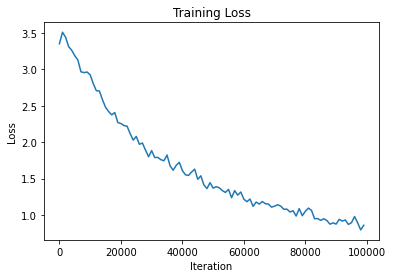

In [82]:
encoder = Encoder(input_set.n_words, 256).to(device)
decoder = AttnDecoder(256, output_set.n_words).to(device)

save_path = os.getcwd()

train_model(input_set, output_set, encoder, decoder, pairs, n_iters=100000, save_path=save_path, model_name='short_model',
            model_type=model_type, hidden_size=256, dropout=0.1, attention=True, save_every=2000, learning_rate=0.01, benchmark_every=1000, verbose=True)

In [83]:
data_test = pd.concat([x_test, y_test], axis=1)
data_test = data_test.reset_index(drop=True)

df_predictions = predict_on_unknown(input_set, output_set, encoder, decoder, model_type=model_type, df=data_test, max_length=max_length, verbose=True)
if 'Target Account Description' in data_test.columns:
    df_predictions = evaluate_output(df_predictions, data_test, model_type=model_type)
    
df_predictions.head(5)

  0%|          | 11/3380 [00:00<00:31, 107.56it/s]

Generating predictions...


100%|██████████| 3380/3380 [00:26<00:00, 127.64it/s]



Description Bleu score average: 0.60                      
Average predicted description (L4) similarity to target: 72.11%


,Source Account Description,Prediction Account Description,Confidence Score,Target Account Description,Predicted Description Bleu Score,Predicted Description Similarity
0,trd promo mgmt cust specific coupon retailer c...,brand mktg accr other coupon,35.036841,tpm cust coup retail co,0.000,0.39
1,other income non taxable,non operating non non,43.070463,non oie misc miscellaneous income expenses,0.152,0.38
2,fa repayment clearing for investment support,fixed fixed asset man manual,34.707567,construc in progress auc historic value manual,0.134,0.35
3,hrs intra inter company revenue hrs reo,i c sls intercompany intra i c,54.008005,i c sls hrs ia c i c revenue hrs reo,0.403,0.48
4,billing adj bb,resrv dbt bil adj,69.617451,resrv for bil adj eb,0.584,0.81
